
# NMT with Transformer&BPE


**To do:**

- BPE (youtokentome lib)
- nn.Transformer
- Translater en <--> ru


In [ ]:
! pip install youtokentome

We will use 
https://github.com/VKCOM/YouTokenToMe


In [1]:
%matplotlib inline
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm.auto import tqdm
import unicodedata

import youtokentome as yttm

C:\Users\MAN-MADE\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data

Same en+ru corpus. But this time, as we will represent the data not in the form of words, but in the form of sub-word parts, using Byte Pair Encoding.

In [2]:
# Prepare data and look at it
# In addition to the dictionary, we are also interested in a set of characters
raw_alphabet = set()
alphabet = set()
def normalize(s):
    return "".join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


def preprocess(s):
    raw_alphabet.update(s)
    s = normalize(s.lower().strip())
    s = re.sub(r"[^a-zа-я?.,!]+", " ", s)
    s = re.sub(r"([.!?])", r" \1", s)
    alphabet.update(s)
    return s

pairs = []
with open('eng-rus.txt', 'rb') as fin:
    for line in tqdm(fin.readlines()):
        pair = [preprocess(_) for _ in line.decode('utf-8').split('\t')]
        pairs.append(pair)

print("RAW alphabet {} symbols:".format(len(raw_alphabet)), 
      "".join(sorted(raw_alphabet)))
print("After preprocessing {} symbols: ".format(len(alphabet)), 
      "".join(sorted(alphabet)))
print("There are {} pairs".format(len(pairs)))
print(pairs[10101])

  0%|          | 0/336666 [00:00<?, ?it/s]

RAW alphabet 174 symbols: 
 !"$%&'()+,-./0123456789:;?@ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz «°º»ãçéêîïóöúǘЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяёׁ​–—―‘’… ‽₂€№
After preprocessing 62 symbols:   !,.?abcdefghijklmnopqrstuvwxyzабвгдежзиклмнопрстуфхцчшщъыьэюя
There are 336666 pairs
['let him do it .', 'пусть он это сделает !']


## BPE training

BPE allows us to train a dictionary of arbitrary sizes.

For example, we can make a common dictionary for English and Russian.
To do this, you need to write all available texts into one file and train BPE.

In [4]:
lines = []
for p in pairs:
    lines += p
lines = list(set(lines))
with open("./all.txt", "wb") as fout:
    for line in lines:
        fout.write((line + "\n").encode('utf-8'))


In [5]:
VOCAB = 5000
bpe = yttm.BPE.train(data="./all.txt", vocab_size=VOCAB, model="enru.bpe")


## NB: is it possible to train BPE on the whole dataset

In many tasks, the question about calculating statistics on the entire dataset may arise:

<mark> if _something_ is an important feature, should this _something_ be calculates only on the train, or can we take the entire dataset with validation?</mark>

- is it possible to calculate averages over all available data for the task of time series forecasting
- is it possible to calculate word2vec on the whole dataset
- etc.

There is no simple answer, in this case BPE is not literally a model, but changing statistics can affect the composition of the dictionary.

In [6]:
bpe.encode(lines[0])

[84, 2498, 162, 763, 695, 2455, 66]

In [7]:
print(bpe.encode(lines[:10], output_type=yttm.OutputType.ID))
print(bpe.encode(lines[:10], output_type=yttm.OutputType.SUBWORD))

[[84, 2498, 162, 763, 695, 2455, 66], [82, 349, 4161, 45, 567, 89, 4073, 66], [273, 152, 153, 770, 3029, 128, 3132, 83], [84, 2079, 4584, 213, 115, 2072, 3202, 66], [260, 301, 2485, 3655, 2159, 83], [120, 245, 2994, 41, 460, 66], [84, 3978, 433, 161, 319, 857, 1993, 1472, 66], [166, 107, 897, 369, 350, 2754, 64, 83], [89, 802, 221, 8, 132, 495, 2245, 389, 32, 4554, 66], [169, 80, 326, 673, 752, 66]]
[['▁не', '▁уро', 'ни', '▁этот', '▁ста', 'кан', '▁.'], ['▁том', '▁был', '▁выше', ',', '▁чем', '▁я', '▁ожидал', '▁.'], ['▁как', '▁бы', '▁вы', '▁пере', 'вели', '▁это', '▁предложение', '▁?'], ['▁не', '▁отве', 'чаи', '▁ни', '▁на', '▁какие', '▁вопросы', '▁.'], ['▁what', '▁are', '▁those', '▁flowers', '▁called', '▁?'], ['▁у', '▁тома', '▁кри', 'з', 'ис', '▁.'], ['▁не', '▁хлеб', 'ом', '▁е', 'ди', 'ным', '▁жив', '▁человек', '▁.'], ['▁do', '▁you', '▁still', '▁like', '▁j', 'az', 'z', '▁?'], ['▁я', '▁только', '▁при', 'т', 'во', 'ря', 'лась', '▁сп', 'я', 'щеи', '▁.'], ['▁that', '▁s', '▁your', '▁lo', 'ss',

## BPE Dropout
 
 
(Article: [BPE-Dropout: Simple and Effective Subword Regularization](https://arxiv.org/abs/1910.13267))

In very large BPE dictionaries (5k tokens for two languages is a small dictionary), there is a problem: some tokens are in the dictionary, but are not found in the train data.

They can occur in real data, due to natural processes or typos. To deal with this phenomenon and simply as a regularization, you can use BPE-dropout: random re-partitioning of a string into tokens.

In [8]:
print(bpe.encode(lines[:1], dropout_prob=0.0, output_type=yttm.OutputType.SUBWORD))
print(bpe.encode(lines[:1], dropout_prob=0.2, output_type=yttm.OutputType.SUBWORD))
print(bpe.encode(lines[:1], dropout_prob=0.5, output_type=yttm.OutputType.SUBWORD))

[['▁не', '▁уро', 'ни', '▁этот', '▁ста', 'кан', '▁.']]
[['▁', 'не', '▁уро', 'ни', '▁этот', '▁ста', 'кан', '▁.']]
[['▁', 'н', 'е', '▁у', 'ро', 'ни', '▁', 'э', 'то', 'т', '▁', 'с', 'т', 'а', 'к', 'а', 'н', '▁.']]


C:\Users\MAN-MADE\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


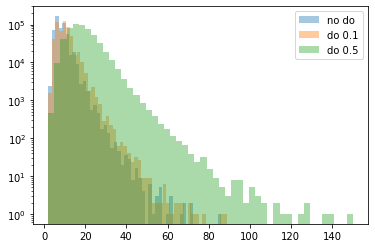

In [9]:
encoded0 = [len(_) for _ in bpe.encode(lines, dropout_prob=0.0)]
encoded1 = [len(_) for _ in bpe.encode(lines, dropout_prob=0.1)]
encoded2 = [len(_) for _ in bpe.encode(lines, dropout_prob=0.5)]

sns.distplot(encoded0, kde=False, label="no do")
sns.distplot(encoded1, kde=False, label="do 0.1")
sns.distplot(encoded2, kde=False, label="do 0.5")
plt.legend()
plt.yscale('log')

In [10]:
# it is proposed to limit the maximum string length to 100 tokens, and to use BPE_DO=0.1 for training
MAX_LENGTH = 100

##dataset

The dataset this time returns a dictionary with en and ru strings, without transformations.

collate_fn is not required for us, and we will describe the conversion to BPE inside the model class.

In [11]:
class Pairset:
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        en, ru = self.data[item]
        return dict(en=en, ru=ru)

train_pairs, val_pairs = train_test_split(pairs, test_size=0.3)

trainset = Pairset(train_pairs)
valset = Pairset(val_pairs)

In [12]:
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)
it = iter(trainloader)
print(next(it))

{'en': ['please don t talk .', 'tom s answer surprised mary .', 'what exactly are you suggesting ?', 'i ll carry this .', 'don t you want to kiss me ?', 'i wish we could spend more time together .', 'you are gorgeous .', 'would you like a dog ?', 'i don t think tom was surprised .', 'who makes breakfast for tom ?', 'tom gave everything he had .', 'i don t speak your language .', 'thanks for supporting me .', 'i must confer with my colleagues on the matter .', 'you re not that old .', 'tom told me where to buy what i needed .'], 'ru': ['не говори, пожалуиста .', 'ответ тома удивил мэри .', 'что именно ты предлагаешь ?', 'я понесу это .', 'не хотите меня поцеловать ?', 'я бы хотел, чтобы мы могли проводить больше времени вместе .', 'ты великолепна .', 'ты бы хотел собаку ?', 'не думаю, что том удивился .', 'кто готовит завтрак для тома ?', 'том отдал все, что у него было .', 'я не говорю на вашем языке .', 'спасибо за поддержку .', 'я должен посовещаться с коллегами по этому вопросу .', 

## Train Loop
It is assumed that the model has two methods:

```
model.compute_all(batch) -> Dict
model.check_translations(batch) -> None
```

In [13]:
def train_model(model, opt, trainloader, valloader, epochs=1):
    step = 0
    logs = defaultdict(list)
    for epoch in range(epochs):
        model.train()
        for batch in tqdm(trainloader):
            details = model.compute_all(batch)
            loss = details["loss"]
            opt.zero_grad()
            loss.backward()
            opt.step()
            step += 1
            [logs[k].append(v) for k, v in details["metrics"].items()]
            
        model.eval()
        tmp = defaultdict(list)
        
        with torch.no_grad():
            for batch in tqdm(valloader):
                details = model.compute_all(batch)
                for k, v in details["metrics"].items():
                    tmp[k].append(v)
            tmp = {k: np.mean(v) for k, v in tmp.items()}
            [logs[f"val_{k}"].append(v) for k, v in tmp.items()]
            logs["step"].append(step)
            model.check_translations(batch)
        
        for key in ["loss"]:
            plt.figure()
            plt.title(key)
            plt.plot(logs[key], label="train", c='b', zorder=1)
            plt.scatter(logs["step"], logs[f"val_{key}"], label="val", c='r', zorder=10)
            plt.legend()
            plt.grid()
            plt.show()

## `nn.Transformer`

The official documentation for (nn.Transformer)[https://pytorch.org/docs/master/generated/torch.nn.Transformer.html#transformer] is rather sparse.

But the important points are:

0. You need to prepare input and output data yourself: you will need to write positional and token embeddings, as well as an output FC layer

1. nn.Transformer.forward takes on running the encoder and applying the decoder correctly.

2. The order of the axes is the same as when using RNN models (for compatibility in seq2seq tasks): `[seq_len, batch_size, dimension]`.

3. Be sure to set `src_key_padding_mask` and `tgt_key_padding_mask` to mask inaccessible tokens (in particular paddings).



It is proposed to have two special tokens: for translation into Russian and into English, with numbers `bpe.vocab_size()` and `bpe.vocab_size() + 1`.
These tokens may not be generated using the output layer, but they may be at the input.



It is proposed to write the following functions:

```
model.encode(list_of_strings) # a function that converts a string into a sequence of BPE token numbers, adds special tokens and padd to MAX_LENGTH
```


```
model.check_translations(batch) # a function that will make and display the translation for a batch with examples
```


```
model.compute_all(batch) # function for training, will run the batch, calculate the loss and return a dictionary with metrics and loss
```

In [19]:
class VeryT(nn.Module):
    def __init__(self, bpe, bpe_dropout=0.1, hidden_size=256):
        super().__init__()
        self.hidden_size = hidden_size
        self.bpe = bpe
        self.bpe_dropout = bpe_dropout
        self.embeddings = nn.Embedding(bpe.vocab_size() + 2, hidden_size)
        self.positional_embeddings = nn.Embedding(MAX_LENGTH, hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size, 
            nhead=8, 
            num_encoder_layers=3, 
            num_decoder_layers=3, dim_feedforward=512)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, bpe.vocab_size()),
            nn.LogSoftmax(dim=-1),
        )
        
        
    def encode(self, lst, pre=None, post=None, seq_len=None, dropout=0.0):
        lst = [self.bpe.encode(entry, dropout_prob=dropout) for entry in lst]
        ## add tokens and paddings
        #<your code>
        print(lst)
        return lst
        
    def check_translations(self, batch):
        en, ru = [batch[key] for key in ["en", "ru"]]
        src = self.encode(en)
        dst = self.encode(ru)
        #<your code if needed>
        src = torch.LongTensor(src)
        dst = torch.LongTensor(dst)
        with torch.no_grad():
            # generate ouput autoregressively
            for i in range(10):  # MAX_LEN - 1
                print('kek')
                #<your code>
            dst = dst.cpu().numpy()
            dst = [line.tolist() for line in dst]
            dst = self.bpe.decode(dst)
            dst = [line.replace("<PAD>", "") for line in dst]
        for line in zip(en, ru, dst):
            print("\t".join(line))
    
    def compute_all(self, batch):
        en, ru = [batch[key] for key in ["en", "ru"]]
        #<formulate task>
        #src = self.encode(en, ...)
        #dst = self.encode(ru, ... )
        
        src = torch.LongTensor(src)
        dst = torch.LongTensor(dst)

        output = self.forward(src, dst)
        
        #<compute loss>
        #loss = ...
        
        return dict(
            loss=loss,
            metrics=dict(
                loss=loss.item(),
            )
        )
        
        
    def forward(self, src, dst):
        # let's a little hack:
        device = next(self.parameters()).device
        src = src.to(device)
        dst = dst.to(device)
        
        
        #<build embeddings for tokens and positional>
        
        # embedded = embedded_tokens * sqrt(hidden_size) + embedded_positions
        
        #<reshape properly>
        
        #<build pad masks>
        src_pad_mask = src != 0
        dst_pad_mask = dst != 0
        
        output = self.transformer(src_embedded, dst_embedded, 
                                  src_key_padding_mask=src_pad_mask, 
                                  tgt_key_padding_mask=dst_pad_mask)
        #<predict next token probs>
        #<permute to [bs, vocab, seq_len]> 
        return output

In [20]:
bpe

In [21]:
# check dimensions
model = VeryT(bpe)
with torch.no_grad():
    batch = next(it)
    model.check_translations(batch)

[[251, 156, 77, 244, 103, 66], [198, 199, 3047, 287, 48, 248, 66], [91, 390, 662, 829, 1031, 124, 426, 1656, 2708, 440, 233, 66], [70, 1262, 107, 278, 513, 208, 316, 251, 66], [70, 231, 67, 333, 169, 139, 400, 716, 66], [70, 92, 858, 369, 72, 263, 66], [91, 615, 416, 963, 208, 1523, 66], [70, 231, 67, 237, 105, 1186, 177, 594, 1574, 260, 139, 446, 166, 1325, 66], [107, 467, 72, 1006, 66], [198, 156, 305, 3950, 424, 2449, 582, 2786, 953, 66], [91, 446, 2189, 66], [647, 70, 991, 564, 1518, 340, 4553, 45, 70, 615, 2372, 72, 564, 66], [70, 263, 91, 390, 4850, 72, 445, 66], [107, 202, 3457, 208, 199, 3511, 522, 66], [105, 904, 156, 630, 3207, 66], [91, 244, 3456, 105, 2619, 103, 66]]
[[128, 1291, 24, 66], [128, 408, 2872, 495, 1521, 56, 368, 66], [82, 510, 2835, 151, 109, 85, 225, 1130, 2764, 66], [1277, 158, 612, 2795, 811, 183, 74, 1199, 66], [89, 84, 472, 116, 223, 2371, 66], [89, 152, 1210, 2118, 2027, 66], [82, 671, 152, 4439, 255, 3898, 66], [84, 1429, 56, 213, 2266, 280, 3123, 2687, 

ValueError: expected sequence of length 6 at dim 1 (got 7)

In [ ]:
if torch.cuda.is_available():
    device="cuda:0"
print(device)

model = VeryT(bpe)
model.to(device)
opt = optim.Adam(model.parameters(), lr=3e-4)


In [ ]:
trainloader = DataLoader(trainset, batch_size=50, shuffle=True)
valloader = DataLoader(valset, batch_size=50, shuffle=False)

train_model(model, opt, trainloader, valloader)